#  Statistical Relational Learning with `pslpython`

Can we build a PSL model for *link prediction* to evaluate the annotations in a friend graph?

In [1]:
from pslpython.model import Model
from pslpython.partition import Partition
from pslpython.predicate import Predicate
from pslpython.rule import Rule

model = Model("simple acquaintances")

# add predicates
predicate = Predicate("Knows", closed=False, size=2)
model.add_predicate(predicate)

predicate = Predicate("Likes", closed=True, size=2)
model.add_predicate(predicate)

predicate = Predicate("Neighbors", closed=True, size=2)
model.add_predicate(predicate)

In [2]:
# add rules
model.add_rule(Rule("20: Neighbors(P1, L) & Neighbors(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))
model.add_rule(Rule("5: Neighbors(P1, L1) & Neighbors(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2) ^2"))

model.add_rule(Rule("10: Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))

model.add_rule(Rule("5: Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3) ^2"))
model.add_rule(Rule("5: !Knows(P1, P2) ^2"))

model.add_rule(Rule("Knows(P1, P2) = Knows(P2, P1) ."))

In [3]:
DATA_DIR = "dat/psl/"

acq = {}

files = [
    "lived_obs.txt",
    "likes_obs.txt",
    "knows_obs.txt",
    "knows_targets.txt",
    "knows_truth.txt",
]

for filename in files:
    col_name = filename.split(".")[0]

    with open(DATA_DIR + filename, "r") as f:
        for line in f:
            row = line.strip().split("\t")
            p1, p2 = row[0:2]
            pair = (p1, p2,)
            
            if len(row) == 3:
                weight = float(row[2])
            else:
                weight = 1.0
        
            if pair not in acq:
                acq[pair] = {}

            acq[pair][col_name] = float(weight)

sorted(acq.items())

[(('0', '0'), {'likes_obs': 0.5792357761763203}),
 (('0', '1'),
  {'likes_obs': 0.8034665712301672, 'knows_targets': 1.0, 'knows_truth': 1.0}),
 (('0', '10'), {'knows_obs': 1.0}),
 (('0', '11'), {'knows_obs': 1.0}),
 (('0', '12'), {'knows_obs': 1.0}),
 (('0', '13'), {'knows_obs': 1.0}),
 (('0', '14'), {'knows_obs': 1.0}),
 (('0', '15'), {'knows_targets': 1.0, 'knows_truth': 1.0}),
 (('0', '16'), {'knows_obs': 1.0}),
 (('0', '17'), {'knows_obs': 1.0}),
 (('0', '18'), {'knows_targets': 1.0, 'knows_truth': 1.0}),
 (('0', '19'), {'knows_obs': 0.0}),
 (('0', '2'), {'likes_obs': 0.6194292469435183, 'knows_obs': 1.0}),
 (('0', '20'), {'knows_obs': 0.0}),
 (('0', '21'), {'knows_obs': 1.0}),
 (('0', '22'), {'knows_targets': 1.0, 'knows_truth': 0.0}),
 (('0', '23'), {'knows_obs': 1.0}),
 (('0', '24'), {'knows_obs': 1.0}),
 (('0', '3'), {'likes_obs': 0.17649495639106194, 'knows_obs': 1.0}),
 (('0', '4'),
  {'lived_obs': 1.0, 'likes_obs': 0.8060242892584343, 'knows_obs': 1.0}),
 (('0', '5'), {'lik

In [4]:
import pandas as pd

row_list = []
columns = ["p1", "p2", "lived_obs", "likes_obs", "knows_obs", "knows_truth", "knows_targets"]

for key, val in acq.items():
    p1, p2 = key
    val["p1"] = p1
    val["p2"] = p2
    row_list.append(val)

df = pd.DataFrame(row_list, columns=columns)
df

,p1,p2,lived_obs,likes_obs,knows_obs,knows_truth,knows_targets
0,0,4,1.0,0.806024,1.0,NaN,NaN
1,1,0,1.0,0.682753,1.0,NaN,NaN
2,1,4,1.0,0.455612,1.0,NaN,NaN
3,2,2,1.0,0.409688,NaN,NaN,NaN
4,2,4,1.0,0.775959,1.0,NaN,NaN
...,...,...,...,...,...,...,...
605,21,22,NaN,NaN,NaN,1.0,1.0
606,21,24,NaN,NaN,NaN,0.0,1.0
607,22,21,NaN,NaN,NaN,1.0,1.0
608,22,24,NaN,NaN,NaN,1.0,1.0


In [5]:
float(round(0.41))

0.0

In [6]:
# add data
for predicate in model.get_predicates().values():
    predicate.clear_data()

predicate = model.get_predicate("Neighbors")

with open(DATA_DIR + "lived_obs.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])
        #print(":person_{} acq:neighbors :person_{} .".format(p1, p2))

predicate = model.get_predicate("Likes")

with open(DATA_DIR + "likes_obs.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        truth = float(row[2])
        truth = float(round(truth))
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=truth)

predicate = model.get_predicate("Knows")

with open(DATA_DIR + "knows_obs.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        truth = float(row[2])
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=truth)

with open(DATA_DIR + "knows_truth.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        truth = float(row[2])
        predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)

with open(DATA_DIR + "knows_targets.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        predicate.add_data_row(Partition.TARGETS, [p1, p2])

In [7]:
# inference

PSL_OPTIONS = {
    "log4j.threshold": "INFO"
}

results = model.infer(additional_cli_optons=[], psl_config=PSL_OPTIONS)

2932 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
3292 [pslpython.model PSL] INFO --- 362  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
3494 [pslpython.model PSL] INFO --- 564  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
3494 [pslpython.model PSL] INFO --- 564  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
3650 [pslpython.model PSL] INFO --- 720  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
3651 [pslpython.model PSL] INFO --- 720  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
3799 [pslpython.model PSL] INFO --- 869  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
4206 [pslpython.model PSL] INFO --- 1276 [main] INFO  org.linqs.psl.

In [8]:
# report results
predicate = model.get_predicates()["KNOWS"]
df = results[predicate]

df

,0,1,truth
0,7,20,0.002162
1,8,13,0.997965
2,8,12,0.995317
3,8,10,0.996837
4,8,21,0.997978
...,...,...,...
113,5,9,0.503015
114,5,7,0.502949
115,6,7,0.996754
116,6,9,0.606499


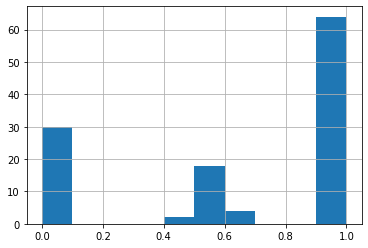

In [9]:
df["truth"].hist()

In [10]:
import kglab

namespaces = {
    "acq": "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    language = "en",
    namespaces = namespaces,
    )

kg.load_ttl("acq.ttl")

In [12]:
VIS_STYLE = {
    "foaf": {
        "color": "orange",
        "size": 5,
    },
    "acq":{
        "color": "blue",
        "size": 30,
    },
}

g = kg.vis_pyvis(notebook=True, style=VIS_STYLE)
g.barnes_hut()
g.show("tmp.html")

In [13]:
kg.save_ttl("foo.ttl")

In [14]:
def get_person_id (url):
    return url.replace("http://example.org/stuff/person_", "")

In [15]:
# reset the PSL network data
for predicate in model.get_predicates().values():
    predicate.clear_data()

In [16]:
predicate = model.get_predicate("Neighbors")

query = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
      ?p1 foaf:based_near ?l .
      ?p2 foaf:based_near ?l .
  }
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])

    if p1 != p2:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])

In [17]:
predicate = model.get_predicate("Likes")
    
query = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
      ?p1 foaf:topic_interest ?t .
      ?p2 foaf:topic_interest ?t .
  }
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])

    if p1 != p2:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])

In [18]:
predicate = model.get_predicate("Likes")
predicate.__dict__

{'_types': [<ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>,
  <ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>],
 '_data': {<Partition.OBSERVATIONS: 'observations'>:       0   1    2
  0    14  23  1.0
  1    14  18  1.0
  2    14   2  1.0
  3    14   6  1.0
  4    14  13  1.0
  ..   ..  ..  ...
  567  20  23  1.0
  568  11  17  1.0
  569  11  20  1.0
  570  11   6  1.0
  571  11  23  1.0
  
  [572 rows x 3 columns],
  <Partition.TARGETS: 'targets'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: [],
  <Partition.TRUTH: 'truth'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: []},
 '_name': 'LIKES',
 '_closed': True}

In [19]:
import csv
import pandas as pd
import rdflib as rdf

targets = []
rows_list = []
predicate = model.get_predicate("Knows")

with open("dat/psl/knows_targets.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for i, row in enumerate(reader):
        p1, p2 = row
        targets.append((p1, p2))
    
        p1_url = rdf.URIRef("http://example.org/stuff/person_" + p1)
        p2_url = rdf.URIRef("http://example.org/stuff/person_" + p2)
        
        if (p1_url, kg.get_ns("foaf").knows, p2_url) in kg._g:
            truth = 1.0
            predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)
            predicate.add_data_row(Partition.TARGETS, [p1, p2])
            rows_list.append({ 0: p1, 1: p2, "truth": truth})
        elif (p1_url, kg.get_ns("acq").wantsIntro, p2_url) in kg._g:
            truth = 0.0
            predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)
            predicate.add_data_row(Partition.TARGETS, [p1, p2])
            rows_list.append({ 0: p1, 1: p2, "truth": truth})
        else:
            print("UNKNOWN", p1, p2)

df_dat = pd.DataFrame(rows_list)   

In [20]:
predicate = model.get_predicate("Knows")

query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 foaf:knows ?p2 .
  }
  ORDER BY ?p1 ?p2
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])
    
    if (p1, p2) not in targets:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=1.0)
    
query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 acq:wantsIntro ?p2 .
  }
  ORDER BY ?p1 ?p2
        """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])
    
    if (p1, p2) not in targets:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=0.0)

In [21]:
# inference

PSL_OPTIONS = {
    "log4j.threshold": "INFO"
}

results = model.infer(additional_cli_optons=[], psl_config=PSL_OPTIONS)

10791 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
11025 [pslpython.model PSL] INFO --- 235  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
11330 [pslpython.model PSL] INFO --- 540  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
11331 [pslpython.model PSL] INFO --- 540  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
11484 [pslpython.model PSL] INFO --- 694  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
11484 [pslpython.model PSL] INFO --- 694  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
11659 [pslpython.model PSL] INFO --- 869  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
17374 [pslpython.model PSL] INFO --- 6584 [main] INFO  org.li

In [22]:
# report results
predicate = model.get_predicates()["KNOWS"]
df = results[predicate]

df

,0,1,truth
0,7,20,0.002999
1,8,13,0.983522
2,8,12,0.980347
3,8,10,0.986561
4,8,21,0.977027
...,...,...,...
113,5,9,0.256436
114,5,7,0.245458
115,6,7,0.991629
116,6,9,0.235500


In [48]:
dat_val = {}

for index, row in df_dat.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    dat_val[key] = row["truth"]

for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    df.at[index, "diff"] = row["truth"] - dat_val[key]

df

,0,1,truth,diff
0,7,20,0.002999,0.002999
1,8,13,0.983522,-0.016478
2,8,12,0.980347,-0.019653
3,8,10,0.986561,-0.013439
4,8,21,0.977027,-0.022973
...,...,...,...,...
113,5,9,0.256436,-0.743564
114,5,7,0.245458,-0.754542
115,6,7,0.991629,-0.008371
116,6,9,0.235500,0.235500


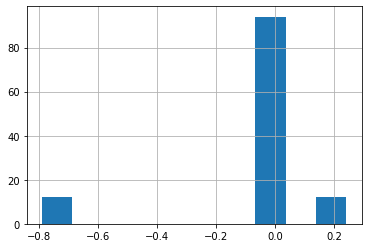

In [46]:
df["diff"].hist()

In [49]:
for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    diff = row["diff"]
    
    if diff < -0.2:
        print("?? acq:person_{} foaf:knows acq:person_{}".format(int(row[0]), int(row[1])))

?? acq:person_21 foaf:knows acq:person_12
?? acq:person_21 foaf:knows acq:person_22
?? acq:person_22 foaf:knows acq:person_21
?? acq:person_5 foaf:knows acq:person_22
?? acq:person_6 foaf:knows acq:person_12
?? acq:person_12 foaf:knows acq:person_6
?? acq:person_7 foaf:knows acq:person_5
?? acq:person_9 foaf:knows acq:person_5
?? acq:person_12 foaf:knows acq:person_21
?? acq:person_22 foaf:knows acq:person_5
?? acq:person_5 foaf:knows acq:person_9
?? acq:person_5 foaf:knows acq:person_7
